<a href="https://colab.research.google.com/github/tamayodb/CCDEPLRL_EXERCISES/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7

Text Generation using LSTM

In [157]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [158]:
tokenizer = Tokenizer()

!wget --no-check-certificate \
    https://raw.githubusercontent.com/cibernox/storyteller/refs/heads/master/snow-white.txt \
    -O /tmp/snowwhite.txt

data = open('/tmp/snowwhite.txt').read()

--2025-05-27 09:06:30--  https://raw.githubusercontent.com/cibernox/storyteller/refs/heads/master/snow-white.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [text/plain]
Saving to: ‘/tmp/snowwhite.txt’

/tmp/snowwhite.txt  100%[===================>]   1.48K  --.-KB/s    in 0s      

2025-05-27 09:06:30 (25.5 MB/s) - ‘/tmp/snowwhite.txt’ saved [1520/1520]



In [159]:
corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

## Create the LSTM model

1. Build an LSTM

In [160]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [161]:
model = Sequential()
model.add(Embedding(
    input_dim=total_words,
    output_dim=200,
    input_length=max_sequence_len-1,
    mask_zero=True
))

model.add(LayerNormalization())

model.add(Bidirectional(LSTM(
    units=256,
    return_sequences=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    kernel_regularizer=regularizers.l2(0.01)
)))

model.add(Dropout(0.4))

model.add(LSTM(
    units=128,
    return_sequences=False,
    dropout=0.3,
    recurrent_dropout=0.3,
    kernel_regularizer=regularizers.l2(0.01)
))


model.add(Dense(
    units=total_words//2,
    activation='gelu',
    kernel_regularizer=regularizers.l2(0.01),
    bias_regularizer=regularizers.l1(0.01)
))

model.add(Dropout(0.5))

model.add(Dense(
    units=total_words,
    activation='softmax'
))

optimizer = Adam(
    learning_rate=0.0008,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [162]:
callbacks = [

    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),

    ModelCheckpoint(
        'best_lstm_model.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [163]:
history = model.fit(
    predictors,
    label,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0129 - loss: 17.8305 - top_k_categorical_accuracy: 0.0129
Epoch 1: val_loss improved from inf to 17.12276, saving model to best_lstm_model.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.0120 - loss: 17.8079 - top_k_categorical_accuracy: 0.0120 - val_accuracy: 0.0000e+00 - val_loss: 17.1228 - val_top_k_categorical_accuracy: 0.0612 - learning_rate: 8.0000e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.0155 - loss: 17.0481 - top_k_categorical_accuracy: 0.0748
Epoch 2: val_loss improved from 17.12276 to 16.38800, saving model to best_lstm_model.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.0154 - loss: 17.0272 - top_k_categorical_accuracy: 0.0737 - val_accuracy: 0.0204 - val_loss: 16.3880 - val_top_k_categorical_accuracy: 0.0408 - learning_rate: 8.0000e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.0141 - loss: 16.3189 - top_k_categorical_accuracy: 0

In [164]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
top_k_acc = history.history['top_k_categorical_accuracy']
val_top_k_acc = history.history['val_top_k_categorical_accuracy']

epochs = range(1, len(acc) + 1)

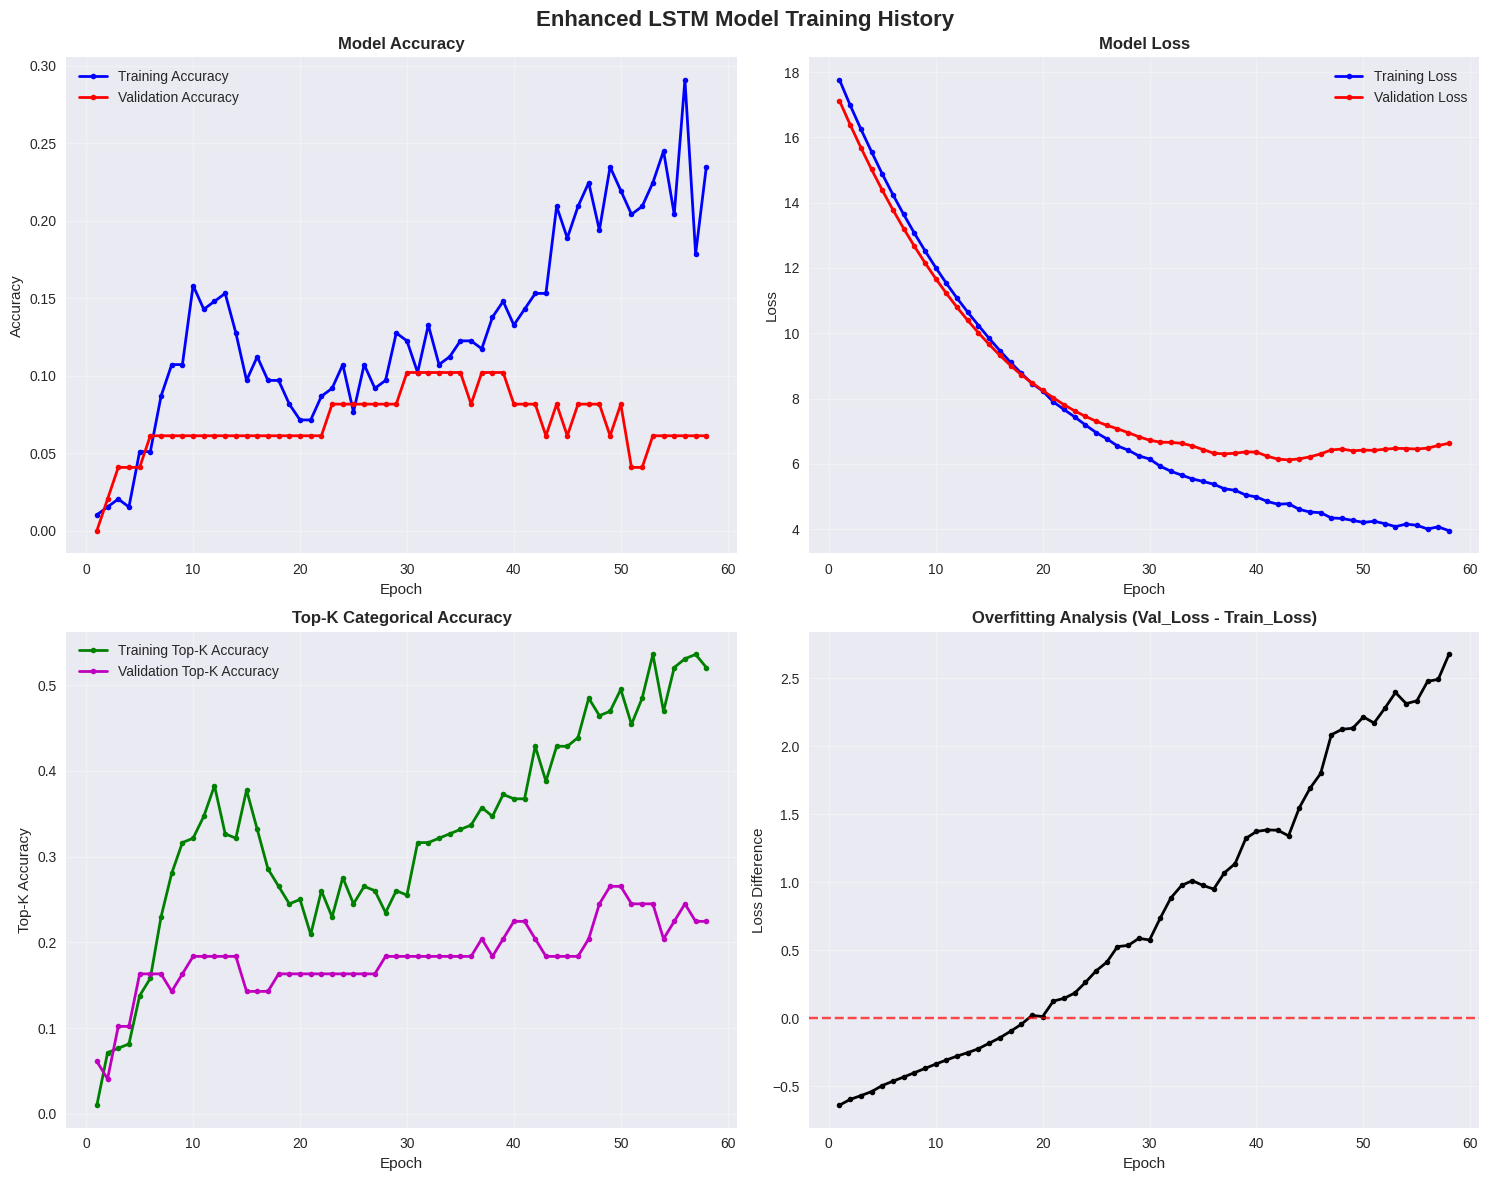

Final Training Accuracy: 0.2347
Final Validation Accuracy: 0.0612
Final Training Loss: 3.9514
Final Validation Loss: 6.6280
Best Validation Accuracy: 0.1020 (Epoch 30)
Total Training Epochs: 58


In [165]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Enhanced LSTM Model Training History', fontsize=16, fontweight='bold')

axes[0, 0].plot(epochs, acc, 'bo-', label='Training Accuracy', linewidth=2, markersize=4)
axes[0, 0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy', linewidth=2, markersize=4)
axes[0, 0].set_title('Model Accuracy', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(epochs, loss, 'bo-', label='Training Loss', linewidth=2, markersize=4)
axes[0, 1].plot(epochs, val_loss, 'ro-', label='Validation Loss', linewidth=2, markersize=4)
axes[0, 1].set_title('Model Loss', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(epochs, top_k_acc, 'go-', label='Training Top-K Accuracy', linewidth=2, markersize=4)
axes[1, 0].plot(epochs, val_top_k_acc, 'mo-', label='Validation Top-K Accuracy', linewidth=2, markersize=4)
axes[1, 0].set_title('Top-K Categorical Accuracy', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Top-K Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

if 'lr' in history.history:
    lr_values = history.history['lr']
    axes[1, 1].plot(epochs, lr_values, 'co-', linewidth=2, markersize=4)
    axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].plot(epochs, np.array(val_loss) - np.array(loss), 'ko-', linewidth=2, markersize=4)
    axes[1, 1].set_title('Overfitting Analysis (Val_Loss - Train_Loss)', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss Difference')
    axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.7)
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]
best_val_acc = max(val_acc)
best_epoch = val_acc.index(best_val_acc) + 1

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"Total Training Epochs: {len(epochs)}")

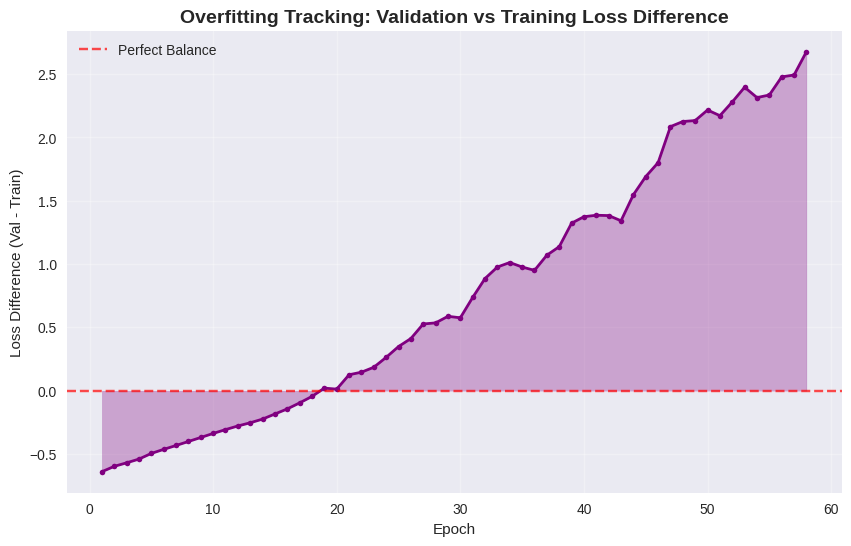

In [166]:
plt.figure(figsize=(10, 6))
loss_diff = np.array(val_loss) - np.array(loss)
plt.plot(epochs, loss_diff, 'purple', linewidth=2, marker='o', markersize=4)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Perfect Balance')
plt.fill_between(epochs, loss_diff, 0, alpha=0.3, color='purple')
plt.title('Overfitting Tracking: Validation vs Training Loss Difference', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss Difference (Val - Train)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## B. Generate texts


In [200]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_with_temperature(seed_text, next_words, model, tokenizer, max_sequence_len, temperature = 0.8):
    generated = seed_text

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([generated])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        predicted_probs = model.predict(token_list, verbose=0)[0]

        scaled_probs = np.log(predicted_probs + 1e-8) / temperature
        scaled_probs = np.exp(scaled_probs)
        scaled_probs = scaled_probs / np.sum(scaled_probs)

        predicted_index = np.random.choice(len(scaled_probs), p=scaled_probs)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break

        if output_word:
            generated += " " + output_word
        else:
            break

    return generated


2. "Snow White lived in the forest with..."

In [201]:
seed_text = "Once upon a time in the middle of winter"
next_words = 50

print("Generated Text")
result = generate_with_temperature(seed_text, next_words, model, tokenizer, max_sequence_len, temperature=1.0)
print(result)


Generated Text
Once upon a time in the middle of winter tree a and skin a calling courage and servant him and in the rival then rival beside innocent her calling rid in in the him him a majesty asked happy and was he are white the majesty always her magic called little came the sitting she off wall bribed blue


3. "The queen looked into the mirror and said..."

In [202]:
seed_text = "The queen looked into the mirror and said"
next_words = 50

print("Generated Text")
result = generate_with_temperature(seed_text, next_words, model, tokenizer, max_sequence_len, temperature=1.0)
print(result)

Generated Text
The queen looked into the mirror and said the courage jealous was rid could little sounds far led white the deed when he she and unseen fair when are lady the to put spot to she was fair land little he led the was always land this beautiful and the to in the in the innocent to calling


4. "One day, Snow White found a small cottage and..."

In [203]:
seed_text = "One day, Snow White found a small cottage and"
next_words = 50

print("Generated Text")
result = generate_with_temperature(seed_text, next_words, model, tokenizer, max_sequence_len, temperature=1.0)
print(result)

Generated Text
One day, Snow White found a small cottage and to mirror away to the of the always little sitting fatal the to wall girl this get rival bitterly trusty of in the her to in the this when alone she mumbled long beautiful white the she happy and to the are when came her off little when this him


In [218]:
seed_text = "Snow white is"
next_words = 5

print("Generated Text")
result = generate_with_temperature(seed_text, next_words, model, tokenizer, max_sequence_len, temperature=0.8)
print(result)

Generated Text
Snow white is pretty the trusty to in


In [215]:
seed_text = "Snow white is the"
next_words = 20

print("Generated Text")
result = generate_with_temperature(seed_text, next_words, model, tokenizer, max_sequence_len, temperature=0.8)
print(result)

Generated Text
Snow white is the are she was and rival to to in the in white she spot take eyes white the she delicate beautiful
